In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import sys, os
sys.path.insert(0, os.path.abspath(".."))
from modules.bnn_functions import *
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

NameError: name 'date' is not defined

In [ ]:
target = "AAPL"
SPY_daily = yf.download(target)
full_df = SPY_daily
full_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600
...,...,...,...,...,...,...
2024-02-16,183.419998,184.850006,181.669998,182.309998,182.309998,49701400
2024-02-20,181.789993,182.429993,180.000000,181.559998,181.559998,53665600
2024-02-21,181.940002,182.889999,180.660004,182.320007,182.320007,41529700


In [ ]:
errors=full_df.isna().any(axis=1)
errors[errors==True]

Series([], dtype: bool)

In [ ]:
def create_lagged_columns(df, n, target):
    for i in range(1, n + 1):
        df[f"{target}_lag_{i}"] = df[target].shift(i)
    return df

def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

def yfinance_labeler(df, hold_period, upper_lower_multipliers):
    vol_df = get_Daily_Volatility(df.Close)
    df = df.reindex(vol_df.index)
    prices = df["Close"]
    labels = []

    for row in range(0,len(vol_df)):
        if ((len(vol_df)-row) - hold_period) > 0:
            upper_bound = prices[row] + prices[row] * upper_lower_multipliers[0] * vol_df[row]
            lower_bound = prices[row] - prices[row] * upper_lower_multipliers[1] * vol_df[row]
            
            pot_bucket = np.array(list(prices[row+1: row+1+hold_period]))
            index_up_min = None
            index_low_min = None

            if (pot_bucket>=upper_bound).any():
                index_up_min = np.argmax(pot_bucket>=upper_bound)
            if (pot_bucket<=lower_bound).any():
                index_low_min = np.argmax(pot_bucket<=lower_bound)

            if (index_up_min is not None) & (index_low_min is not None):
                if index_up_min<index_low_min:
                    labels.append(1)
                else:
                    labels.append(0)
            elif index_up_min is not None:
                labels.append(1)
            elif index_low_min is not None:
                labels.append(0)
            else:
                labels.append(0) #hier könnte das dritte label stehen
        else:
            labels.append(12)
    print(len(labels))
    df["vola"] = vol_df
    df["label"] = labels

    df_output = df[df["label"] != 12]
    return(df_output)

In [ ]:
investment_horizon = 10
bound_volas = [2, 1.5]

full_df = yfinance_labeler(full_df, investment_horizon, bound_volas)
full_df

10888


,Open,High,Low,Close,Adj Close,Volume,vola,label
Date,,,,,,,,
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000,0.015010,1
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600,0.053096,1
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600,0.052657,1
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097467,48630400,0.057076,1
1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102211,37363200,0.053510,1
...,...,...,...,...,...,...,...,...
2024-02-02,179.860001,187.330002,179.250000,185.850006,185.613159,102518000,0.013116,0
2024-02-05,188.149994,189.250000,185.839996,187.679993,187.440811,69668800,0.012949,0
2024-02-06,186.860001,189.309998,186.770004,189.300003,189.058762,43490800,0.012625,0


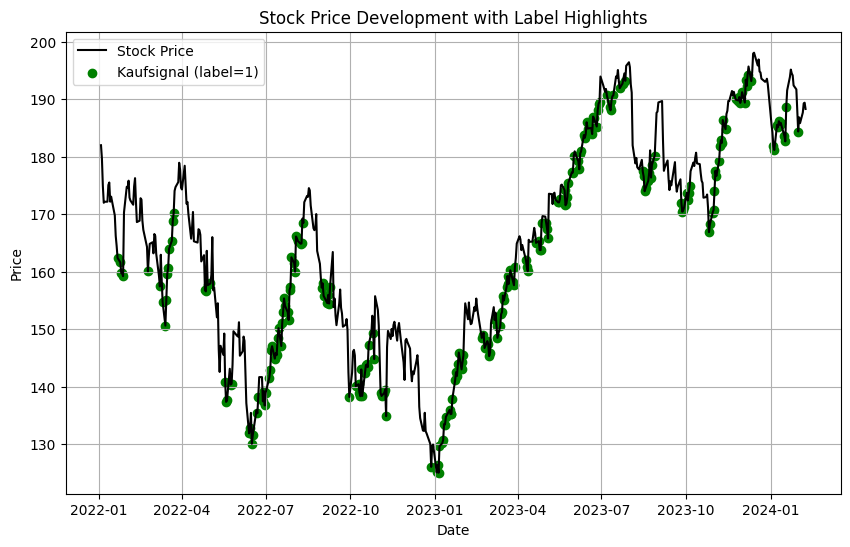

In [ ]:
plot_df = full_df["2022-01-01":]

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[plot_df['label'] == 1].index, plot_df[plot_df['label'] == 1]['Close'], color='green', label='Kaufsignal (label=1)')

# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
nine_period_high = full_df['High'].rolling(window= 9).max()
nine_period_low = full_df['Low'].rolling(window= 9).min()
tenkan_sen = (nine_period_high + nine_period_low) /2
full_df['tenkan_sen_perc'] = tenkan_sen.pct_change(1)
# Kijun-sen (Base Line): (26-period high + 26-period low)/2))
period26_high = full_df['High'].rolling(window=26).max()
period26_low = full_df['Low'].rolling(window=26).min()
kijun_sen = (period26_high + period26_low) / 2
full_df['kijun_sen_perc'] = kijun_sen.pct_change(1)
# Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)
full_df['senkou_span_a_perc'] = senkou_span_a.pct_change(1)
# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
period52_high = full_df['High'].rolling(window=52).max()
period52_low = full_df['Low'].rolling(window=52).min()
senkou_span_b = ((period52_high + period52_low) / 2).shift(26)
full_df['senkou_span_b_perc'] = senkou_span_b.pct_change(1)

var_list = [tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b]
names_list = ["tenkan_sen", "kijun_sen", "senkou_span_a", "senkou_span_b"]
for var, name in zip(var_list,names_list):
    colname = name+"_higher_close"
    full_df[colname] = [1 if a > b else 0 for a, b in zip(var, list(full_df["Close"]))]
    
full_df["tenkan_sen_higher_kijun_sen"] = [1 if a > b else 0 for a, b in zip(tenkan_sen, kijun_sen)]
full_df["tenkan_sen_kijun_sen_DIFF"] = tenkan_sen - kijun_sen

full_df["senkou_span_a_higher_senkou_span_b"] = [1 if a > b else 0 for a, b in zip(senkou_span_a, senkou_span_b)]
full_df["senkou_span_a_senkou_span_b_DIFF"] = senkou_span_a - senkou_span_b

full_df["tenkan_sen_higher_cloud"] = [1 if a > b else 0 for a, b in zip(tenkan_sen, [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)])]
full_df["kijun_sen_higher_cloud"] = [1 if a > b else 0 for a, b in zip(kijun_sen, [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)])]

full_df["tenkan_sen_cloudDIFF"] = tenkan_sen - [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)]
full_df["kijun_sen_cloudDIFF"] = kijun_sen - [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)]

full_df["positive_crossover"] = [1 if x >= 0 and full_df["tenkan_sen_kijun_sen_DIFF"][i - 1] < 0 else 0 for i, x in enumerate(full_df["tenkan_sen_kijun_sen_DIFF"])]
full_df["crossover"] = [1 if (x >= 0 and full_df["tenkan_sen_kijun_sen_DIFF"][i - 1] < 0) or (x <= 0 and full_df["tenkan_sen_kijun_sen_DIFF"][i - 1] > 0) else 0 for i, x in enumerate(full_df["tenkan_sen_kijun_sen_DIFF"])]

crossover_above = []
for val1, val2, val3 in zip([min(c, d) for c, d in zip(tenkan_sen, kijun_sen)], [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)], full_df["crossover"]):
    if val3 == 1 and val1 > val2:
        crossover_above.append(1)
    else:
        crossover_above.append(0)

full_df["crossover_above"] = crossover_above

crossover_below = []
for val1, val2, val3 in zip([min(c, d) for c, d in zip(tenkan_sen, kijun_sen)], [min(c, d) for c, d in zip(senkou_span_a, senkou_span_b)], full_df["crossover"]):
    if val3 == 1 and val1 < val2:
        crossover_below.append(1)
    else:
        crossover_below.append(0)

full_df["crossover_below"] = crossover_below

full_df["positive_crossover_cloud"] = [1 if x >= 0 and full_df["senkou_span_a_senkou_span_b_DIFF"][i - 1] < 0 else 0 for i, x in enumerate(full_df["senkou_span_a_senkou_span_b_DIFF"])]
full_df["crossover_cloud"] = [1 if (x >= 0 and full_df["senkou_span_a_senkou_span_b_DIFF"][i - 1] < 0) or (x <= 0 and full_df["senkou_span_a_senkou_span_b_DIFF"][i - 1] > 0) else 0 for i, x in enumerate(full_df["senkou_span_a_senkou_span_b_DIFF"])]

full_df

,Open,High,Low,Close,Adj Close,Volume,vola,label,tenkan_sen_perc,kijun_sen_perc,...,tenkan_sen_higher_cloud,kijun_sen_higher_cloud,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000,0.015010,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600,0.053096,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600,0.052657,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097467,48630400,0.057076,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102211,37363200,0.053510,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,179.860001,187.330002,179.250000,185.850006,185.613159,102518000,0.013116,0,-0.012020,-0.002443,...,0,0,-7.064995,-7.064995,0,1,0,0,0,0
2024-02-05,188.149994,189.250000,185.839996,187.679993,187.440811,69668800,0.012949,0,0.000000,0.000000,...,0,0,-6.629993,-6.629993,0,0,0,0,0,0
2024-02-06,186.860001,189.309998,186.770004,189.300003,189.058762,43490800,0.012625,0,-0.000293,0.000000,...,0,0,-6.379993,-6.324993,0,0,0,0,0,0


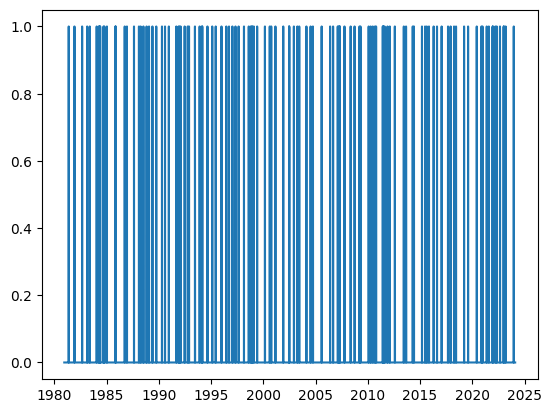

In [ ]:
plt.plot(full_df.index, full_df['positive_crossover_cloud'])

In [ ]:
full_df['close_pct'] = full_df['Close'].pct_change(1)
full_df['Volume_pct'] = full_df['Volume'].pct_change(1)

In [ ]:
full_df.drop(['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [ ]:
# for col in list(full_df.columns):
#     full_df=create_lagged_columns(full_df, 20, col)

In [ ]:
full_df

,vola,label,tenkan_sen_perc,kijun_sen_perc,senkou_span_a_perc,senkou_span_b_perc,tenkan_sen_higher_close,kijun_sen_higher_close,senkou_span_a_higher_close,senkou_span_b_higher_close,...,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud,close_pct,Volume_pct
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-16,0.015010,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,NaN,NaN
1980-12-17,0.053096,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.024751,-0.182415
1980-12-18,0.052657,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.028992,-0.150298
1980-12-19,0.057076,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.061029,-0.337908
1980-12-22,0.053510,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.048670,-0.231690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,0.013116,0,-0.012020,-0.002443,0.001426,0.0,1,1,1,0,...,-7.064995,-7.064995,0,1,0,0,0,0,-0.005405,0.579986
2024-02-05,0.012949,0,0.000000,0.000000,-0.002232,0.0,1,1,1,0,...,-6.629993,-6.629993,0,0,0,0,0,0,0.009847,-0.320424
2024-02-06,0.012625,0,-0.000293,0.000000,-0.001569,0.0,0,0,1,0,...,-6.379993,-6.324993,0,0,0,0,0,0,0.008632,-0.375749


In [ ]:
test_begin = "2018-01-01"
full_df.dropna(inplace=True)
train_df = full_df[:test_begin]
test_df = full_df[test_begin:]

In [ ]:
Xs_train = train_df.drop('label', axis=1).values
Xs_test = test_df.drop('label', axis=1).values
Ys_train = train_df['label'].values
Ys_test = test_df['label'].values

In [ ]:
# MLP params
hidden_layer_width = 10
n_hidden_layers = 5

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

In [ ]:
# probabilities_train = final_model.predict_proba(X_full)
# probabilities_train_positive = probabilities_train[:, 1]

# #Create a Precision/Recall curve for our training data
# precision_train, recall_train, pr_thresholds_train = precision_recall_curve(y_full, probabilities_train_positive)
# fscore_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

# #Find optimal thresh on PR curve train
# ix = np.argmax(fscore_train)
# optimal_threshold = pr_thresholds_train[ix]

In [ ]:
rng_key, eval_key = jax.random.split(rng_key)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid= None, num_steps=600,batch_size_particles = 50, batch_size_data = 64, num_particles=400
    )

Ys_pred_train, Ys_pred_test, _ = fit_and_eval_single_mlp(eval_key, Xs_train, Ys_train, Xs_test)

100%|██████████| 600/600 [01:17<00:00,  7.76it/s]


0.0
0.0


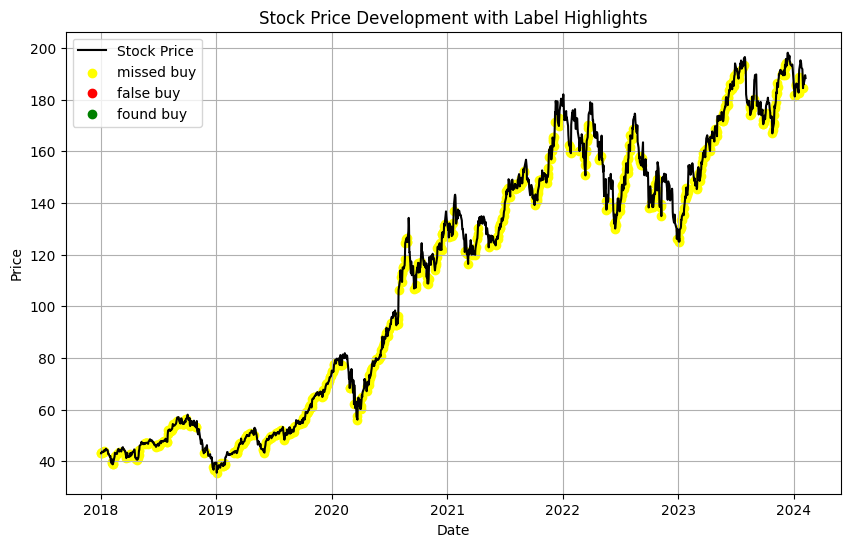

In [ ]:
# Add Close prices back to df to see the visualization
prices = SPY_daily[test_begin:]["Close"]
plot_df = test_df.copy()
plot_df["Close"] = prices
plot_df["signal"] = Ys_pred_test.astype(int)

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)]['Close'], color='yellow', label='missed buy')
plt.scatter(plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)]['Close'], color='red', label='false buy')
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)]['Close'], color='green', label='found buy')

# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Train accuracy = 60.41%
Test accuracy = 53.32%
